# Predicting Crime in the City of Chicago



Crime is part of any society, however the responses to crime varies from culture to culture.  It is the responsibility of society to try to protect its citizens and one way of doing this is with the reduction of crime.

In this project, I look through records of previous crimes in the City of Chicago and in doing so so hope to predict when crime is likely to occur and as such turn the vast amount of data that the City collections into actionable suggestions.

## Table of Cotent:
* [Introduction](#Introduction)
* [Data Preparation](#Data)
* [Data Exploration](#explore)
    * [Monthly Crimes](#month)
    * [Top Crimes](#top)
* [Predicting Arrest](#pre)
* [Conslusion](#con)
* [Future Investigation](#fut)
* [References & Acknowledgement](#ref)

# Introduction <a class="anchor" id="Introduction"></a>

The data set is provided by the City of Chicago at https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2,  this is a record of all reported crimes and is updated daily by the City. The data is currated by the Chicago police force.  The data starts on 2001 and goes up to the present and is all crime reported inside the city limits.  

In [1]:
import numpy as np
import csv
import pandas as pd
import datetime

from sklearn.svm import SVC
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

SIZE_MONTH = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
DATE_FILTER = "01-01-2019"




For this project we will only need 3 different packages for the project.  CSV is used because the data is downloaded from the City of Chicago in csv format. Pandas and numpy are used to allow us to handle the larger size of the data.  We have about 7 million data points in this data set and as such we will have more than enough data to do an analysis and get good results.

# Data Preparation <a class="anchor" id="Data"></a>

We first downloaded the most recent data from the City of Chicago and then renamed it and placed it in the same folder as the notebook.  We load in the data using csv

In [2]:
data = pd.read_csv("chicago_data.csv")
#This is the data of crimes reported to chicago PD
#Please be aware that the data contained in the csv is roughly 1.7gb in form and when loaded into panda data frames increase
#to about 3GiB in memory due to dataframe overhead.  Would recommend not running on older labtops or any computer 
#with less than 8gb of memory

/home/exx/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7020214 entries, 0 to 7020213
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.1+ GB
None


Above is the data that is presented to us for each crime reported in the system.  I will quickly cover a few key points.  "IUCR" is the Illinois Uniform Crime Reportin codes.  These are four digit codes that allow us identify which type of crime has been commited and then normall a descriptor for certain cases.  For example code 820 has the primary descriptor as "THEFT" and a secondary descriptor of "\\$500 AND UNDER" which tells us that less than \\$500 of goods was stolen.  "Arrest" is a bool with "True" meaning an arrest has been made and "False" if an arrest has not been made for the crime. 

In [4]:
Date_Type = pd.DatetimeIndex(data['Date'])
data["Month"] = Date_Type.month

We use this to allow us to quickly find which month the crime was commited in.

# Data Exploration <a class="anchor" id="explore"></a>

There is a natural question as to whether or not the crimes of the past can be used to predict crimes of the future.  There are plenty of proposed systems that seem to have a high level of reliability. The website below is a paper on a system that uses spatial-temporal history of crime to create a prediction of hot-spots.  So the literature supports the success of using historical data for crime prediction.

https://ieeexplore.ieee.org/document/7860234

In [5]:
print(data.Year.unique())
Number_of_Years = len(data.Year.unique())

[2001 2017 2013 2015 2012 2014 2006 2011 2007 2010 2008 2016 2003 2018
 2009 2002 2005 2004 2019]


We can see that the range of values for the data is from 2001 to 2019 so our analysis will involve only look at data from that time range.  I chose to use the entire data set instead of a subset of the time due to discoveries that will be talked about later on.  

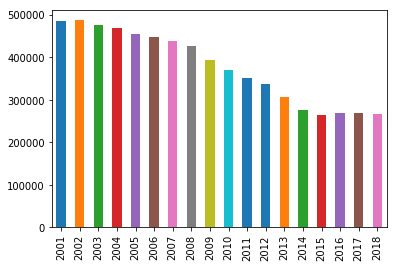

In [25]:
crimes_by_year = data["Year"].value_counts().sort_index()
crimes_by_year.plot(kind="bar")


We can see that over time we have a generalized trend of crimes going down over time.  We would like to look at what trends are affecting the city so as to have this decrease in crime rates.  This was part of the reason as to why I chose to look at the data for the entire period of time.  This decreasing trend can be furthered analyized to look for underlying cause which we could use in the future.

# Crime By Month  <a class="anchor" id="month"></a>
We often look at crimes occuring "around the holidays" and have other such assumptions so it would be interesting to look and see if this saying is true.  To do so we first looked to see if all crimes combined were committed with more or less frequency during certain parts of the year.  We will be filtering out the data from 2019 for the monthly analysis due to the year having not concluded.  

In [7]:
try:
    data["Date"] = Date_Type
except:
    pass
data = data[data['Date'] < DATE_FILTER]
crimes_by_month = data["Month"].value_counts().sort_index()
print("Total number of crimes in pre-2019: ", len(data))

Total number of crimes in pre-2019:  6786985


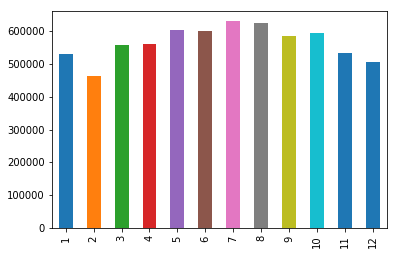

In [8]:
crimes_by_month.plot(kind="bar")

From the visual we can clearly see that there are less reported crimes during winter months, especially Febuary.  However this difference could be due to the difference sizes of each month, so we must normalize for the different sizes of the month to look at the probability a crime is commited on a random day.

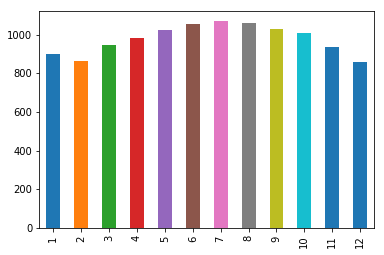

In [9]:
monthly_crimes_normalized = crimes_by_month/SIZE_MONTH/Number_of_Years
monthly_crimes_normalized.plot(kind="bar")

Even with this corrective measure in place we can still see that there is a trend between the months and now with the normalized crime per day in that month the trend seems to be more sinusoidal.  

Parameters for the function is:  [2.76078201e+02 7.81352329e+02 2.30501406e-01]
Parameter Covariance:  [[ 1.03367229e+03 -7.60447787e+02 -4.99198768e-02]
 [-7.60447787e+02  6.30333880e+02  5.67592422e-02]
 [-4.99198768e-02  5.67592422e-02  4.01694875e-05]]


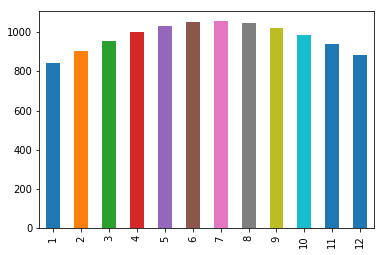

In [10]:
def function(x,a,b,c):
    return b + a*np.sin(c*x)
param, param_cov = curve_fit(function,monthly_crimes_normalized.index,monthly_crimes_normalized, p0=[300,801,0])
print("Parameters for the function is: ", param)
print("Parameter Covariance: ", param_cov)

x_r = [i+1 for i in range(12)]

estimate = pd.Series([function(x,param[0],param[1],param[2]) for x in x_r])
estimate.index = x_r

estimate.plot(kind="bar")




The above plot is the estimate for the best sinusodial function for the given monthly normalized data. The y axis is the amount of crime reported on average per day in that month.  

R squared is:  0.8970768742728408


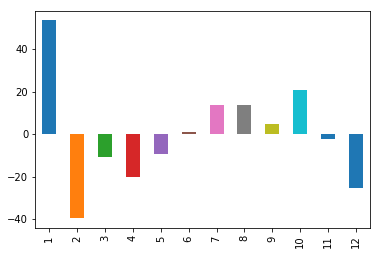

In [11]:
residuals = monthly_crimes_normalized-estimate
ss_res = np.sum(residuals**2)

ss_total = np.sum((monthly_crimes_normalized-np.mean(monthly_crimes_normalized))**2)


residuals.plot(kind="bar")
r_squared = 1 - (ss_res / ss_total)

print("R squared is: ", r_squared)



There appears to that the data is a close approximation, with an R squared value of about .897, which means we can explain roughly 67% of the change solely due to the change in the Month.  I do not believe this means that criminals are look at their calendars for whether or not they should commit a crime.  There is probably a correlation between the warmer months and the crime reported due to some underlying event that affects both categories.

In [12]:
crimes_solved_by_month = data.query('Arrest == True')["Month"].value_counts().sort_index()/SIZE_MONTH/Number_of_Years

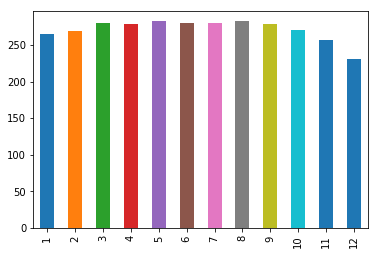

In [13]:
crimes_solved_by_month.plot(kind="bar")

We looked at a normalized amount of crimes solved per month.  This counts the number of crimes solved in that month, normalized for the amount of years and the size of the month(number of days). 

In [14]:
frac_time_solved_month = crimes_solved_by_month/monthly_crimes_normalized

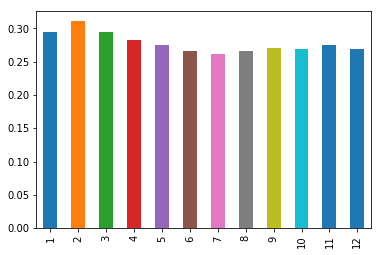

In [15]:
frac_time_solved_month.plot(kind="bar")

The above graph is the percentage of crimes that are reported in a certain month that are eventually have an arrest associated to them.  We consider those cases solved and as such would like to to see these numbers be as close to 1 as possible.  This would be that every case is solved.

In [16]:
crimes_by_type = data["IUCR"].value_counts().sort_index()

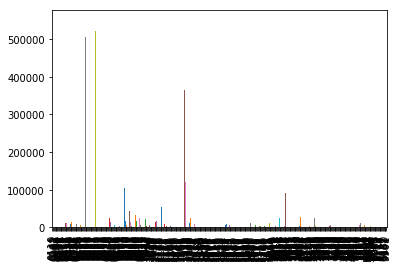

In [17]:
crimes_by_type.plot(kind="bar")

We can see from the above graph that there are a few type of crimes that make up the majority of crimes that are committed.  We will restrict our analysis to the 10 most common crimes.

# Top Crimes <a class="anchor" id="top"></a>

In this section we will be look at the top 10 most common crimes and continue an analysis of them.

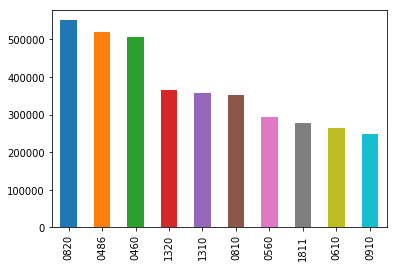

In [18]:
crimes_by_type.nlargest(10).plot(kind="Bar")

The above crimes are in order (Theft, \\$500 and Under), (Battery, Domestic Battery Simple), (Battery, Simple), (Criminal Damage, To Vehicle), (Criminal Damage, To Property), (Theft, Over \\$500), (Assault, Simple), (Narcotics, Poss:Cannabis 30GMS or Less), (Burglary, Forcible Entry), (Motor Vehicle Theft, Autombile).  These crimes represent the majority of crimes that take place in the City of Chicago ans as such we will pay attentions to them since a larger list will result in the results not being human readable.

In [19]:
look_at = ["0820","0486","0460","1320","1310","0810","0560","1811","0610","0910"]
crimes_solved_by_type = data.query('Arrest == True').query('IUCR in @look_at')["IUCR"].value_counts().sort_index()

In [20]:
frac_time_solved_type = crimes_solved_by_type/crimes_by_type.nlargest(10)

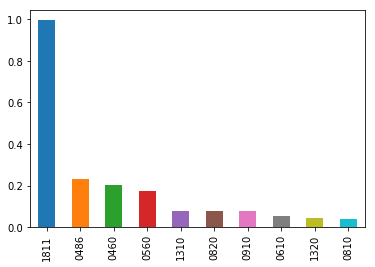

In [21]:
frac_time_solved_type.nlargest(10).plot(kind="Bar")

This generates an interesting example for us, there seems to be 2 types of crimes, ones were people will report or can report and ones were officiers have to actively look for them.  1811 seems to be a case of where crimes are unlikely to be reported, unless there is an arrest made, it is possession of under 30 grames of cannabis.

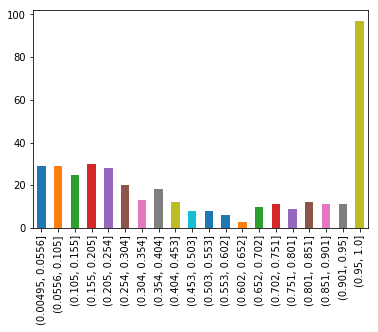

In [22]:
#Only look at crimes that there are an arrest
crimes_solved_by_type = data.query('Arrest == True')["IUCR"].value_counts()/crimes_by_type
crimes_solved = pd.Series(crimes_solved_by_type.values)

#Bucket the type of crimes into bins based on arrest rate
ranges = pd.cut(crimes_solved,bins=20)
crimes_solved.groupby(ranges).count().plot(kind="bar")

Above we can see that there is really no middle ground in the type of arrests, either a vast majority of reports have an associated arrest for a type of crime, or the opposite is true.  This shows strong evidence for a previously stated idea of there being two types of crimes based on arrest to report percentage.  The reaons for this are not going to be talked about, but I will propose an idea in the "Future Investigation" tab.  

# Predicting Arrest  <a class="anchor" id="pre"></a>

There are two ways of going about the utilization of the data with the purpose of trying to reduce crime rates.  One is we can try to predict crimes that are going to happen and where they will happen.  The other thing we can do is assume that a crime takes place at this place and find whether or not that person will be caught.  

For this project I will be doing the latter option.  I believe the former result is prone to discrimination by assuming that people in a certain geographic area will commit crime.  I believe the latter method, while definitely not perfect will result in a more unbiased, usable and understandable metric, probability of arrest given a crime is committed. This makes sense to people since we want to arrest someone if they commit a crime, and hopefully this could be used, along with a weight matrix on where to move officiers.

I believe this fits in with other research as a way of approaching the same goal, but with a different value set.  While most projects try to predict and reduce crime by predicting it occurring, this project tries to find the probability of an arrest being made, if a crime of a certain type occurs.  So it is a different way of looking at the same problem.

For this we will only look at the top 10 examples of crimes

In [26]:
#First process the data
top_ten = ["0820","0486","0460","1320","1310","0810","0560","1811","0610","0910"]
Top_ten_data = data.query('IUCR in @look_at')
Top_ten_data = Top_ten_data.drop(columns=["Case Number","Location","Primary Type","Date","Updated On", "FBI Code", "Location Description","Description","Block"])
Top_ten_data.fillna(value=0, inplace=True)
#print(Top_ten_data["Description"].unique())
classifier = SVC(gamma="auto")

#Do not run this program unless you have alot of time, it will take a long time to compute
#The first drop is to make the set more managable
X_train, X_test, Y_train, Y_test = train_test_split(Top_ten_data,Top_ten_data["Arrest"], test_size = .15, random_state =0)
X_train = X_train.drop(columns=["Arrest"])
#Dropped to remove the ability to see if arrest is made
X_train, X_test, Y_train, Y_test = train_test_split(X_test,Y_test, test_size = .2, random_state =0)
classifier.fit(X_train,Y_train)


In [27]:
print(classifier.score(X_test,Y_test))

0.814780042918455


The classifier.score function tests the classifier to see if it can predict what we want it to.  With a result of 81.4%, we can see that the classifier does much better than average in guessing whether or not an arrest will be made.  The fact that this simple classifier is able to correctly guess at 81.4% indicates a strong predictiveness in the data.  

# Conclusions <a class="anchor" id="con"></a>

While there have been very large scale results that have seen success of trying to predict crime and using analysis to try to reduce the amount of crime all of these have used very complex and high-end computing systems.  This project take an innovative approach due to much smaller computing ability than compared to current systems.

We showed that we have shown that given a crime is committed that from historical data we can figure out whether or not the criminal will be caught.  This is extremely useful for us because it gives us a probability matrix of whether or not a criminal will be arrested given that a crime occurs, we could use this and the distribution of crimes committed, along with a societal "cost" for a type of crime and from there we can figure out where we should place officiers to help reduce the cost that crime has on society.  This work will not be covered due to the need for more computing power and the idea of trying to calculate societal cost of crime is a hard problem to do with the given information and no easy way to collect more of it.

This classifier also shows us that the task is possible, even when restricting the data and using a simple SVM.  This classifier could be used to help rearrange locations where officiers are placed.  We could use A/B testing and find a optimial placement for maximizing arrest rates.  This would improve Chicago's safety.

# Future Investigation <a class="anchor" id="fut"></a>

It would be interesting to see correlation between where officers are placed and the amount of crime reported.  This is due to the fact that the data given to us is biased.  We can see this bias in the fact that 27 types of crimes have a 100% report to arrest rate, meaning that they most likely are types of crimes that are not reported, but are arrested for if an officer sees you.  This is probably some form of selection bias on the part of the populus of Chicago.  The data required to find where officiers are located is a requirement that this project was unable to recieve.

Public perception of crime is also an interesting area of study, and the difference in arrest rates could be used for such a study.  Above we showed that there are two types of crimes when it comes to arrest rates, ones with very high arrest rates and ones with very low arrest rates.  This difference can be important to see if we can use this information to predict the effect these crimes have on other people.  For example, if we have a high arrest rate for a type of crime, it is possible that for that type of crime people do not perceive it to affect time, thus they rarely report.

A study could also be done to try to isolate which pieces of information are being used by the SVM.  This would be useful for us trying to find underlying trends in crime rates.


# Reference and Acknowledgement <a class="anchor" id="ref"></a>
For copy of the data used in this analysis please look at https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e/data

Special thanks to Professor Kolter and the 15-388 course staff of F'19